In [1]:
import piexif
import lensfunpy
from lensfunpy import XMLFormatError
import rawpy
import cv2
import numpy as np

try:
    db = lensfunpy.Database()
except XMLFormatError:
# if there is a format error, attempt to use locally bundled xmls
    db = lensfunpy.Database(paths=glob.glob('libs/lensfunpy-db/*.xml')) # For future use    

In [2]:
def openImageFile(imgPath, usr_gamma = 2.2,
                  demosaic=rawpy.DemosaicAlgorithm.AHD):
    """ given an image path, attempts to return a numpy array image object
    """
    gamma_value = (usr_gamma, usr_gamma)
    try:  # use rawpy to convert raw to openCV
        with rawpy.imread(imgPath) as raw:
            im = raw.postprocess(chromatic_aberration=(1, 1),
                                  demosaic_algorithm=demosaic,
                                  gamma=gamma_value,
                                  output_color=rawpy.ColorSpace.raw)

    # if it is not a raw format, just try and open it.
    except LibRawNonFatalError:
        bgr = cv2.imread(imgPath)
        im = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    except LibRawFatalError:
        if imgPath == '':
            raise
        text = 'Corrupted or incompatible image file.'
        title = 'Error opening file'
        detail_text = f'LibRawFatalError opening: {imgPath}\nUsually this indicates a corrupted input image file.'
        raise
    return im

def detImagingEquipment(imgPath):
    """ given an image file path, attempts to determine
    the make/model of the camera body and lens. """
    # extract exif data as dict
    exifDict = piexif.load(imgPath)
    imgDict = {}
    for ifd in ("0th", "Exif", "GPS", "1st"):
        for tag in exifDict[ifd]:
            tagName = (piexif.TAGS[ifd][tag]["name"])#, exif_dict[ifd][tag])
            #print(piexif.TAGS[ifd][tag]["name"], exifDict[ifd][tag])
            #if tagName.lower() in ('make','model','lensmaker','lensmodel','focallength', 'fnumber'):
            imgDict[tagName.lower()] = exifDict[ifd][tag]
    for k,v in imgDict.items():
        if isinstance(v, bytes):
            imgDict[k] = v.decode("utf-8")
    return imgDict
    #'Artist'
    #'Copyright'
    camMaker = imgDict.get('make','')
    camModel = imgDict.get('model','')
    lensMaker = imgDict.get('lensmaker','')
    lensModel = imgDict.get('lensmodel','')
    focalLength = imgDict.get('focallength','')[0]
    apertureValue = imgDict.get('fnumber','')[0]

    # load the equipment database
    # lookup the camera details
    cam = db.find_cameras(camMaker, camModel, loose_search=False)[0]
    # lookup the lens details
    lens = db.find_lenses(cam, lensMaker, lensModel, loose_search=False)[0]
    # organize the result into a dict.
    result = {'cam':cam,
              'lens':lens,
              'focalLength':focalLength,
              'apertureValue':apertureValue}

    # drop keys which are null
    for k,v in result.items():
        if v in ['',None,False]:
            del result[k]

    return result

In [41]:
#imgPath = './exampleImages/various_images/Lisboa-201310659.NEF'
imgPath = './exampleImages/MOBOT_test_set/MO-3130581.CR2'
im = openImageFile(imgPath)

In [42]:
rawimg = rawpy.imread(imgPath)
print(dir(rawimg))

['__class__', '__delattr__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', 'black_level_per_channel', 'camera_whitebalance', 'close', 'color_desc', 'color_matrix', 'daylight_whitebalance', 'dcraw_make_mem_image', 'dcraw_process', 'num_colors', 'open_buffer', 'open_file', 'postprocess', 'raw_color', 'raw_colors', 'raw_colors_visible', 'raw_image', 'raw_image_visible', 'raw_pattern', 'raw_type', 'raw_value', 'raw_value_visible', 'rgb_xyz_matrix', 'sizes', 'tone_curve', 'unpack']


In [49]:
print(rawimg.camera_whitebalance)
print(rawimg.black_level_per_channel)
print(rawimg.color_desc)
print(rawimg.tone_curve)
print(rawimg.raw_colors)
print(rawimg.raw_image)

[1949.0, 1024.0, 1975.0, 1024.0]
[2047, 2048, 2047, 2047]
b'RGBG'
[    0     1     2 ... 65533 65534 65535]
[[0 1 0 ... 1 0 1]
 [3 2 3 ... 2 3 2]
 [0 1 0 ... 1 0 1]
 ...
 [3 2 3 ... 2 3 2]
 [0 1 0 ... 1 0 1]
 [3 2 3 ... 2 3 2]]
[[1994 1900 1943 ... 2009 2068 1970]
 [1956 1869 1899 ... 2022 2055 1968]
 [2060 1979 2026 ... 1984 2047 1924]
 ...
 [2053 2051 2053 ... 2199 2051 2039]
 [2055 2040 2049 ... 2348 2057 2052]
 [2046 2058 2031 ... 2208 2056 2045]]


In [53]:
from matplotlib import pyplot as plt

(3950, 5920)


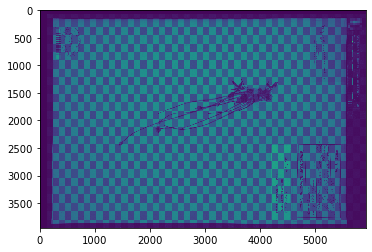

(3950, 5920)


In [61]:
x = rawimg.raw_image
print(x.shape)
plt.imshow(x, interpolation='nearest')
plt.show()
print(x.shape)